# Imports

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

In [37]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [38]:
from tqdm import tqdm

In [39]:
import sys
# mBRSET lives here
PACKAGE_DIR = "/Users/renee/Documents/Tech_Spr25/LabCourse/"

if PACKAGE_DIR not in sys.path:
    sys.path.append(PACKAGE_DIR)

In [40]:
from mBRSET.src.get_dataset import split_data
from mBRSET.src.data_loader import BRSETDataset, process_labels
# loss function and optimizer
from mBRSET.src.FocalLoss import FocalLoss

# train and test functions
from mBRSET.src.train import train
from mBRSET.src.test import test

# Data Paths

Modify data paths with your local path

In [41]:
pwd

'/Users/renee/Documents/E14LabCourse/labcourse'

In [42]:
# DATA_PATH = '/oriondata/AIMLab/renee.zac/Datasets/mbrset/mbrset-a-mobile-brazilian-retinal-dataset-1.0/'
DATA_PATH = '/Users/renee/Documents/Tech_Spr25/LabCourse/Data/mbrset-a-mobile-brazilian-retinal-dataset-1.0'
IMAGES_PATH = os.path.join(DATA_PATH,'images/')
LABELS_CSV_PATH = os.path.join(DATA_PATH,'labels_mbrset.csv')

In [43]:
# vascular biomarkers
VBM_CSV_PATH = './mbrset_vbm_df.csv'

In [44]:
# https://www.physionet.org/content/mbrset/1.0/
# sex: 0 for female and 1 for male
labels_df = pd.read_csv(LABELS_CSV_PATH)
labels_df.head()

,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,acute_myocardial_infarction,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no


In [45]:
len(labels_df)

5164

### Each row unique patients? If multiple images per patient, train-test split with patient-level data kept to one split

In [46]:
len(labels_df.patient.unique())

1291

# Sex-prediction from vascular biomarkers

### Data Preprocessing, Exploration (3.4 Part I)

## Train val split .8/.2 patients

In [47]:
unique_patients = labels_df['patient'].unique()

# for stratification
unique_patients_df = labels_df.drop_duplicates('patient')[['patient', 'sex']]
train_patients, val_patients = train_test_split(unique_patients, test_size=0.2, random_state=42, stratify=unique_patients_df['sex'])

print(f"Train patients: {len(train_patients)}, Validation patients: {len(val_patients)}")

Train patients: 1032, Validation patients: 259


In [48]:
labels_df['Split'] = np.where(labels_df['patient'].isin(train_patients), 'train', 
                              np.where(labels_df['patient'].isin(val_patients), 'val', None))

### What is the image train/val split?

In [49]:
labels_df.Split.value_counts()

Split
train    4128
val      1036
Name: count, dtype: int64

### What is the sex-differentiation split?

In [50]:
labels_df.sex.value_counts()

sex
0    3360
1    1804
Name: count, dtype: int64

#### Are there missing sex-label values which need to be handled? 

## Load Vascular Biomarker Dataset

In [51]:
# Index column corresponds to the image file path
vbm_df = pd.read_csv(VBM_CSV_PATH)
vbm_df.head()

,Artery_Area,Artery_Tortuosity_Index,Artery_Median_Tortuosity,Artery_Overall_Length,Artery_Median_Branching_Angles,Artery_N_Start_Points,Artery_N_End_Points,Artery_N_Intersection_Points,Vein_Area,Vein_Tortuosity_Index,Vein_Median_Tortuosity,Vein_Overall_Length,Vein_Median_Branching_Angles,Vein_N_Start_Points,Vein_N_End_Points,Vein_N_Intersection_Points,Index
0,20578.0,1.101783,1.075637,1555.893578,70.575740,4,5.0,1.0,49007.0,1.092587,1.084222,4196.864499,77.275644,4,13.0,12.0,47.4
1,49634.0,1.103772,1.087451,5520.839246,91.702621,9,17.0,9.0,57754.0,1.093053,1.081833,6274.276980,68.813001,11,25.0,14.0,378.3
2,39278.0,1.077895,1.074380,5061.986433,69.167245,9,14.0,5.0,47080.0,1.093832,1.079156,5861.105407,66.551865,8,19.0,13.0,207.1
3,34729.0,1.091477,1.084032,5386.770270,92.364036,7,13.0,5.0,38741.0,1.099560,1.081481,5342.461613,79.777831,8,16.0,11.0,1075.2
4,25567.0,1.064010,1.069275,2744.438959,62.311646,6,9.0,4.0,23127.0,1.079073,1.081001,2076.973880,74.009028,4,5.0,1.0,1023.3


### Check that there are no null Index values to check that each row (sample) has a corresponding image file

Also check each is unique to use as index for join

In [52]:
np.unique(vbm_df['Index']).shape[0] == len(vbm_df)

True

## Linear Separability of sex from vascular biomarker features

Use linear regression to predict sex (labels_df 'sex' column) from data (vbm_df) where data are split by labels_df 

In [53]:
# set index to img file name for join
vbm_df = vbm_df.set_index('Index')
# Prepare join key for labels_df (remove file extension)
labels_df['vbm_index'] = labels_df['file'].str.replace('.jpg', '', regex=False)

# Ensure vbm_df index is string for join
vbm_df.index = vbm_df.index.astype(str)

# Only keep rows in labels_df where vbm_index is present in vbm_df
labels_df_matched = labels_df[labels_df['vbm_index'].isin(vbm_df.index)].copy()

# Join labels_df to vbm_df
merged = labels_df_matched.join(vbm_df, on='vbm_index')

# Prepare features and targets for train/val splits
X_train = merged[merged['Split'] == 'train'][vbm_df.columns]
y_train = merged[merged['Split'] == 'train']['sex']
X_val = merged[merged['Split'] == 'val'][vbm_df.columns]
y_val = merged[merged['Split'] == 'val']['sex']

# Check for empty feature set
if X_train.shape[1] == 0 or X_val.shape[1] == 0:
	print("No matching features found after join. Please check your join keys!")
else:
	# Impute missing values
	imputer = SimpleImputer(strategy='mean')
	X_train_imputed = imputer.fit_transform(X_train)
	X_val_imputed = imputer.transform(X_val)

	# Fit linear regression
	lr = LinearRegression()
	lr.fit(X_train_imputed, y_train)

	# Predict on validation set
	y_val_pred = lr.predict(X_val_imputed)
	y_val_pred_binary = (y_val_pred >= 0.5).astype(int)

	# Evaluate
	acc = accuracy_score(y_val, y_val_pred_binary)
	auc = roc_auc_score(y_val, y_val_pred)

	print(f"Validation Accuracy: {acc:.3f}")
	print(f"Validation ROC AUC: {auc:.3f}")

Validation Accuracy: 0.655
Validation ROC AUC: 0.591


In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

# Linear Regression (thresholded)
lr_precision = precision_score(y_val, y_val_pred_binary)
lr_recall = recall_score(y_val, y_val_pred_binary)
lr_f1 = f1_score(y_val, y_val_pred_binary)

print("Linear Regression (thresholded at 0.5):")
print(f"Precision: {lr_precision:.3f}")
print(f"Recall: {lr_recall:.3f}")
print(f"F1 Score: {lr_f1:.3f}")



Linear Regression (thresholded at 0.5):
Precision: 0.615
Recall: 0.022
F1 Score: 0.043


### Visualize Linear Regression Feature importance

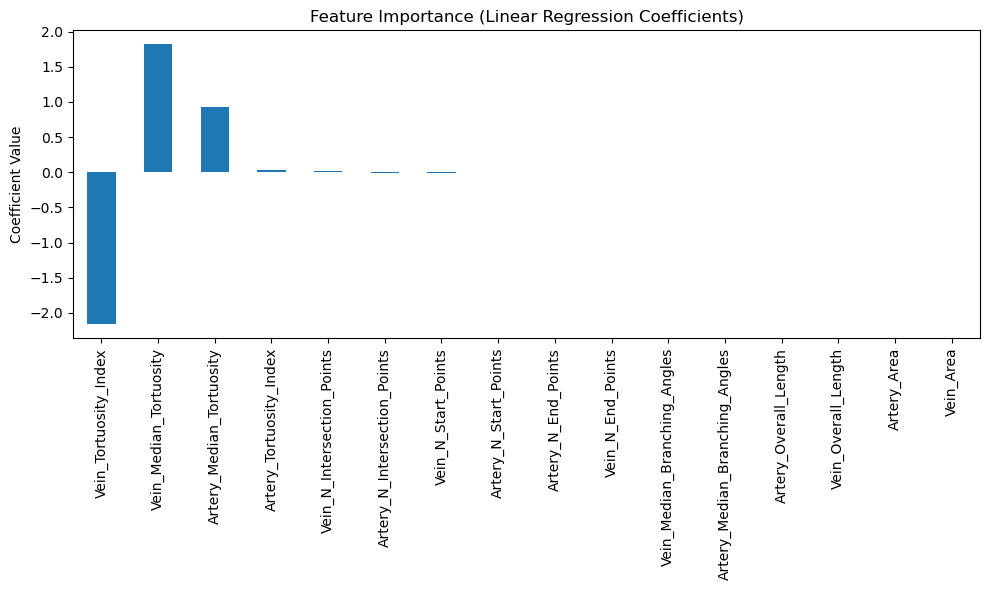

In [55]:
# Get feature importances (coefficients) from the linear regression model
feature_importance = pd.Series(lr.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

### Use Non-Linear Model for more generalized separability of sex from vascular biomarkers

Report Model Performance and visualize feature importance

Random Forest Validation Accuracy: 0.625
Random Forest Validation ROC AUC: 0.556


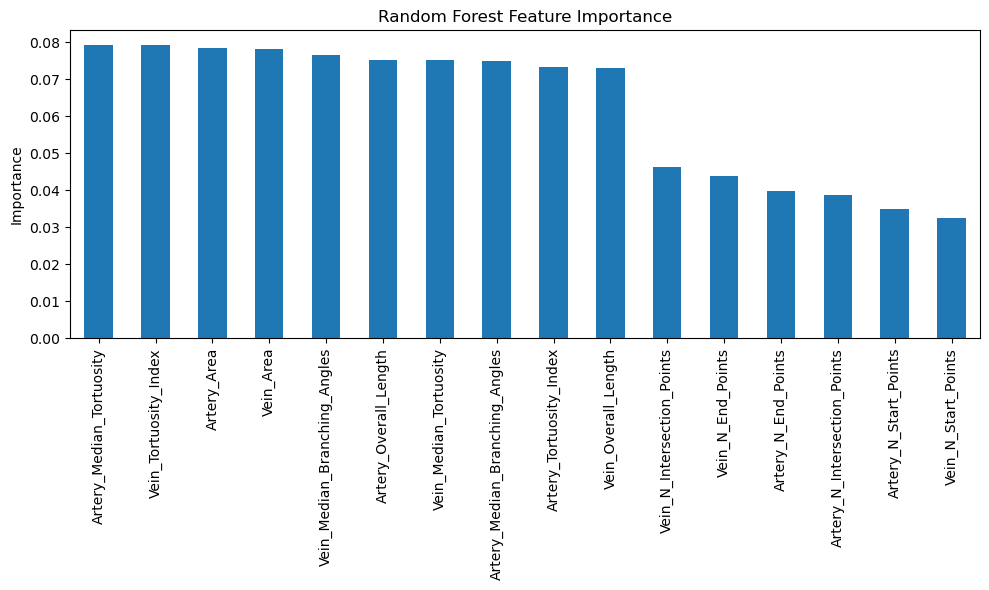

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest on imputed data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_imputed, y_train)

# Predict on validation set
y_val_rf_pred = rf.predict_proba(X_val_imputed)[:, 1]
y_val_rf_pred_binary = (y_val_rf_pred >= 0.5).astype(int)

# Evaluate
rf_acc = accuracy_score(y_val, y_val_rf_pred_binary)
rf_auc = roc_auc_score(y_val, y_val_rf_pred)

print(f"Random Forest Validation Accuracy: {rf_acc:.3f}")
print(f"Random Forest Validation ROC AUC: {rf_auc:.3f}")

# Feature importance
rf_feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
rf_feature_importance.plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [57]:
# Random Forest
rf_precision = precision_score(y_val, y_val_rf_pred_binary)
rf_recall = recall_score(y_val, y_val_rf_pred_binary)
rf_f1 = f1_score(y_val, y_val_rf_pred_binary)

print("\nRandom Forest:")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall: {rf_recall:.3f}")
print(f"F1 Score: {rf_f1:.3f}")



Random Forest:
Precision: 0.329
Recall: 0.075
F1 Score: 0.122


Linear Regression (thresholded at 0.5):
              precision    recall  f1-score   support

  Female (0)       0.66      0.99      0.79       676
    Male (1)       0.62      0.02      0.04       360

    accuracy                           0.66      1036
   macro avg       0.64      0.51      0.42      1036
weighted avg       0.64      0.66      0.53      1036



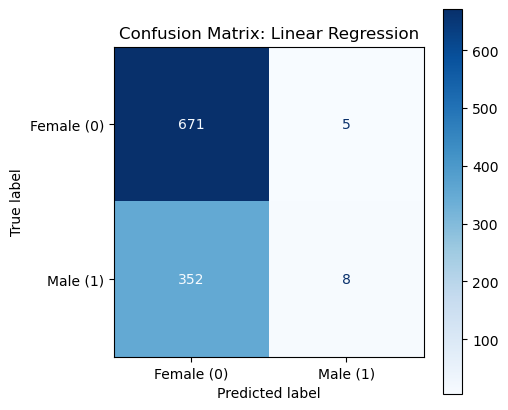

Random Forest:
              precision    recall  f1-score   support

  Female (0)       0.65      0.92      0.76       676
    Male (1)       0.33      0.07      0.12       360

    accuracy                           0.63      1036
   macro avg       0.49      0.50      0.44      1036
weighted avg       0.54      0.63      0.54      1036



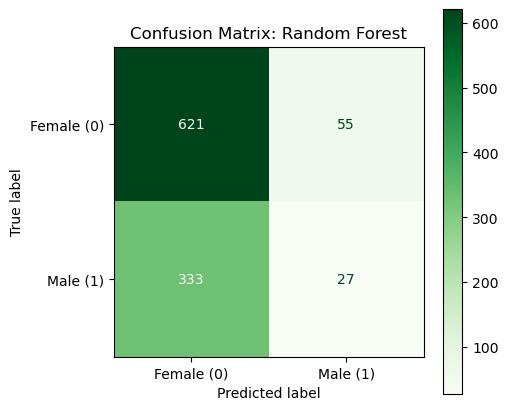

In [58]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

# Linear Regression (thresholded)
print("Linear Regression (thresholded at 0.5):")
print(classification_report(y_val, y_val_pred_binary, target_names=["Female (0)", "Male (1)"]))

cm_lr = confusion_matrix(y_val, y_val_pred_binary)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Female (0)", "Male (1)"])
fig, ax = plt.subplots(figsize=(5, 5))
disp_lr.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Linear Regression")
plt.show()

# Random Forest
print("Random Forest:")
print(classification_report(y_val, y_val_rf_pred_binary, target_names=["Female (0)", "Male (1)"]))

cm_rf = confusion_matrix(y_val, y_val_rf_pred_binary)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Female (0)", "Male (1)"])
fig, ax = plt.subplots(figsize=(5, 5))
disp_rf.plot(ax=ax, cmap='Greens', values_format='d')
plt.title("Confusion Matrix: Random Forest")
plt.show()

# Pixel-based deep learning for predicting sex from fundus images

## ConvNeXt V2-Large

ConvNeXt V2-Large is a fully-convulutional neural network (CNN) (without attention layers) which borrows some principles from vision transformers (ViTs) <br> including parsing the input image into non-overlapping patches and learning their embeddings. <br> As a CNN, ConvNeXt V2-Large architecture has translation equivariance with local inductive bias, presuming a complex feature can be found anywhere in the image and that images are structured with nearby pixels related to each other. <br> These assumptions are useful in medical imaging: imagine the need to identify an exudate or edema anywhere in a fundus image. <br> Among the models tested for sex differentiation by mBRSET, ConvNeXt performed best with the highest F1 score (84.4%) in classifying sex from fundus images.

In [59]:
# Imagenet mean, std
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 6
NUM_WORKERS = 4

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5


LABEL = 'sex'
IMAGE_COL = 'file'

TEST_SIZE = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Observe the range in observable vascular definition in portable fundus images

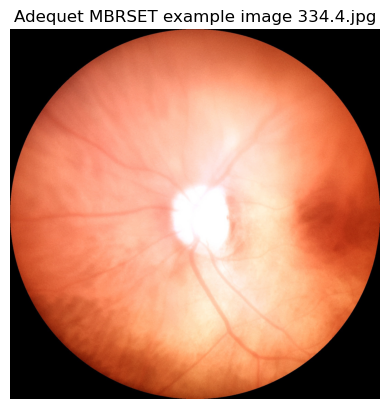

In [60]:
sample = labels_df[labels_df['final_quality'] == 'yes'].iloc[np.random.randint(len(labels_df[labels_df['final_quality'] == 'yes']))]['file']
img = Image.open(os.path.join(IMAGES_PATH, sample))
plt.imshow(img)
plt.title(f"Adequet MBRSET example image {sample}")
plt.axis('off')
plt.show()

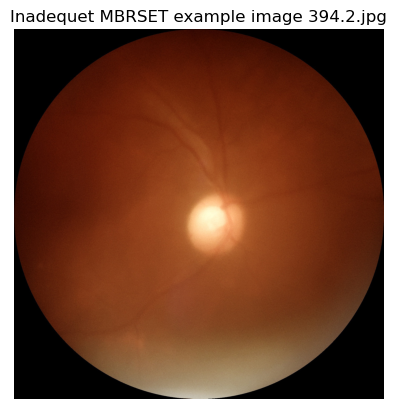

In [61]:
sample = labels_df[labels_df['final_quality'] == 'no'].iloc[np.random.randint(len(labels_df[labels_df['final_quality'] == 'no']))]['file']
# img = files[np.random.randint(0, len(files))]
img = Image.open(os.path.join(IMAGES_PATH, sample)) # Use a specific image for demonstration
plt.imshow(img) #Display the segmentation
plt.title(f"Inadequet MBRSET example image {sample}")
plt.axis('off')
plt.show()

In [62]:
#df_train = labels_df[labels_df['Split'] == 'train']
#df_val = labels_df[labels_df['Split'] == 'val']

### Train, Test Split

In [63]:
labels_df[LABEL] = labels_df[LABEL].astype(int)  # Ensure the label is integer type
labels_df[LABEL] = labels_df[LABEL].apply(lambda x: '1' if x == 1 else '0' )


Train data shape: (4131, 26)
Test data shape: (1033, 26)


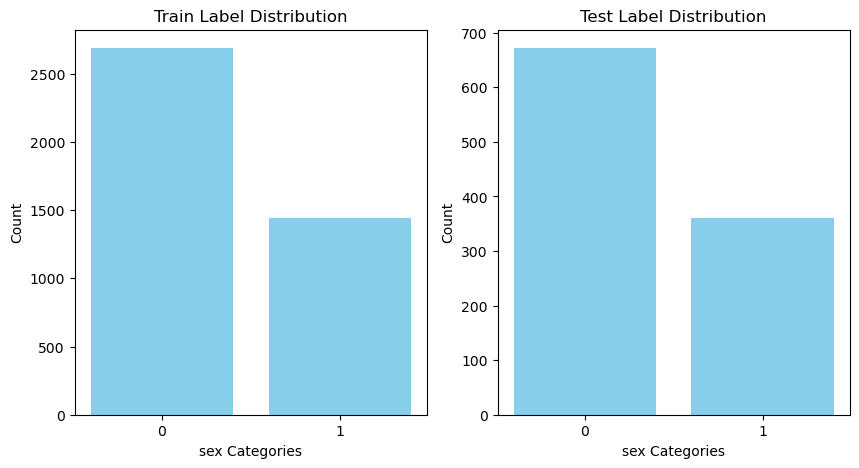

Train set sex concentration: sex
0    0.65069
1    0.34931
Name: proportion, dtype: float64
Validation set sex concentration: sex
0    0.650532
1    0.349468
Name: proportion, dtype: float64


In [64]:
df_train, df_val = split_data(labels_df, LABEL, TEST_SIZE, undersample=False)

# print as concentration of 1s and 0s
print(f"Train set {LABEL} concentration: {df_train[LABEL].value_counts(normalize=True)}")
print(f"Validation set {LABEL} concentration: {df_val[LABEL].value_counts(normalize=True)}")

In [65]:
#the indices (row numbers) of the validation set from the original labels_df
#val_indices = df_val.index.to_list()
#np.save('val_indices.npy', val_indices)
#print(f" {len(val_indices)} validation indices to val_indices.npy")

### Load split for reproducibility and for evaluating on unseen images

In [66]:
# Load validation indices from file
val_indices = np.load('val_indices.npy')

# Split labels_df into train and val sets based on val_indices
df_val = labels_df.loc[val_indices]
df_train = labels_df.drop(val_indices)

df_test = df_val

print(f"Train set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")

Train set size: 4131
Validation set size: 1033


In [67]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [68]:
# Define the target image shape
SHAPE = (384, 384)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [69]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES_PATH, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES_PATH, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES_PATH, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

### Load Model

In [70]:
# Create a DataLoader to generate embeddings
#model = get_retfound(weights='/scratch/liyues_root/liyues/chenweiw/retina_datasets/retfound_weigths/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
from transformers import ConvNextV2Model, ConvNextV2ForImageClassification
import torch

# Load the pre-trained ConvNeXt V2 model
model_name = "facebook/convnextv2-large-22k-384"
model = ConvNextV2ForImageClassification.from_pretrained(model_name)

# Modify the classifier head according to the new number of classes
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


### Training - ignore. Instead, upload pretrained weights provided

if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

### Load saved model

In [ ]:
MODEL_DIR = "/Users/renee/Library/CloudStorage/OneDrive-Technion/LabCourse/Models"


In [80]:
# Load the model weights from the specified path, move to device, and set to eval mode
model_path = os.path.join(MODEL_DIR,"fine_tuned_convnextv2_large_2class_sex_best.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print(f"Loaded model weights from {model_path} and set to eval mode on {device}")

Loaded model weights from /Users/renee/Library/CloudStorage/OneDrive-Technion/LabCourse/Models/fine_tuned_convnextv2_large_2class_sex_best.pth and set to eval mode on cpu


In [81]:
df_val.sex.value_counts()

sex
0    672
1    361
Name: count, dtype: int64

100%|██████████| 1033/1033 [48:42<00:00,  2.83s/it]   


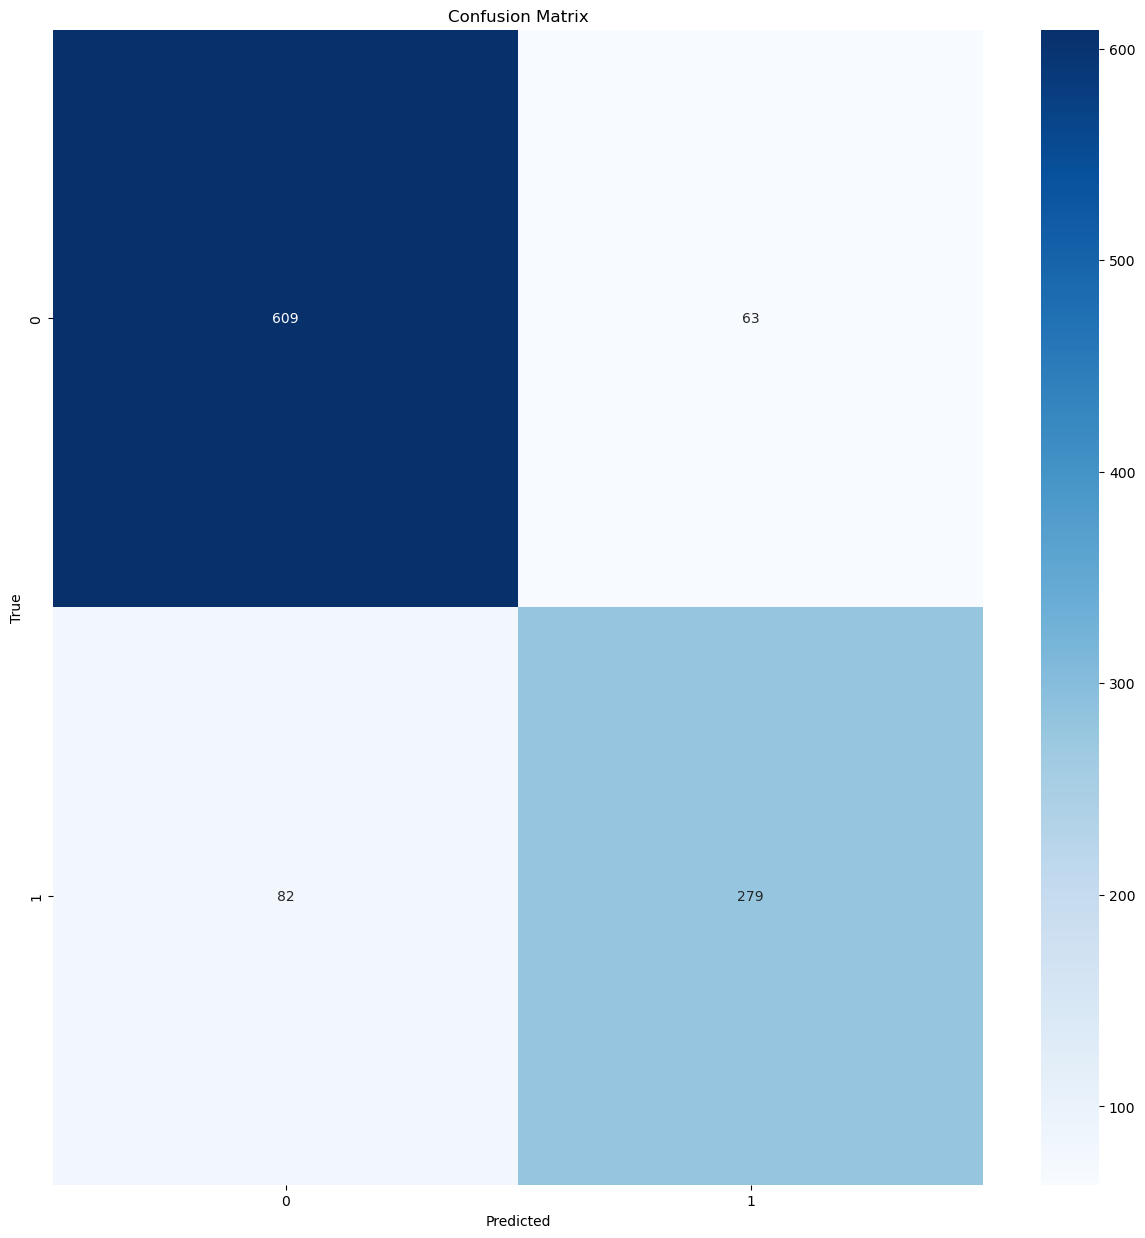

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       672
           1       0.82      0.77      0.79       361

    accuracy                           0.86      1033
   macro avg       0.85      0.84      0.84      1033
weighted avg       0.86      0.86      0.86      1033

##################################################  Saliency Maps  ##################################################

Class 0:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


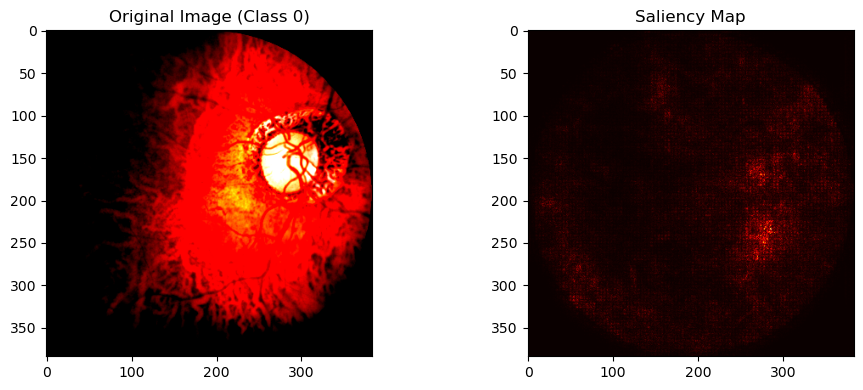

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


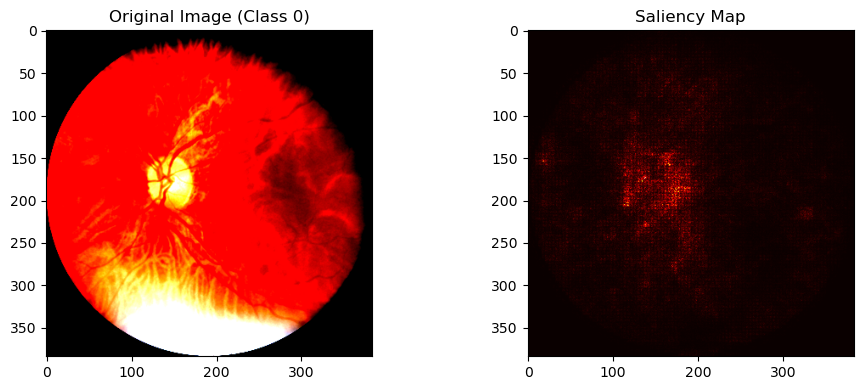

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


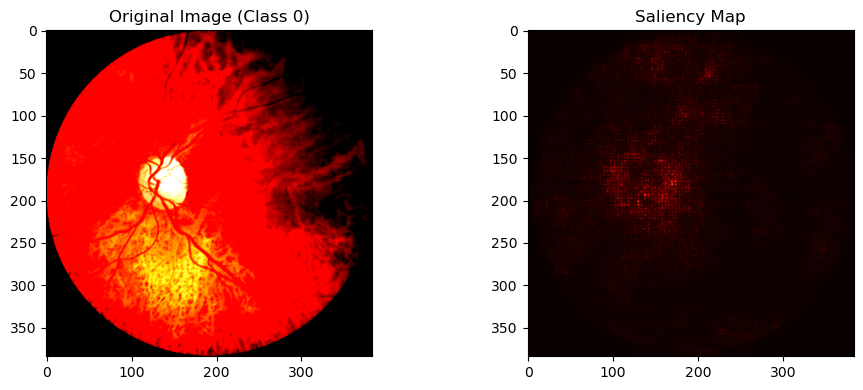

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


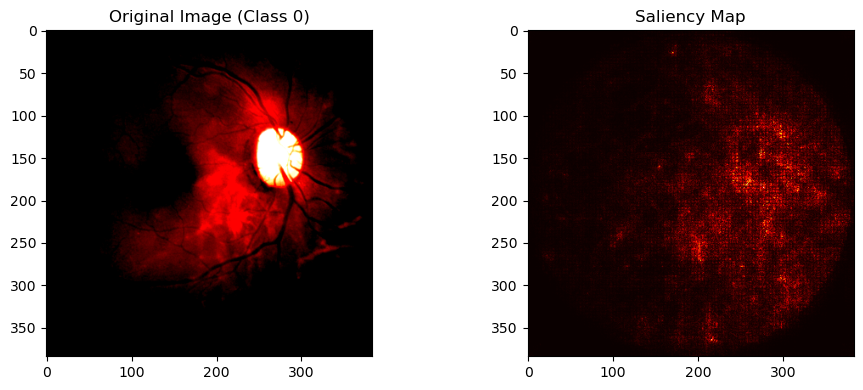

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


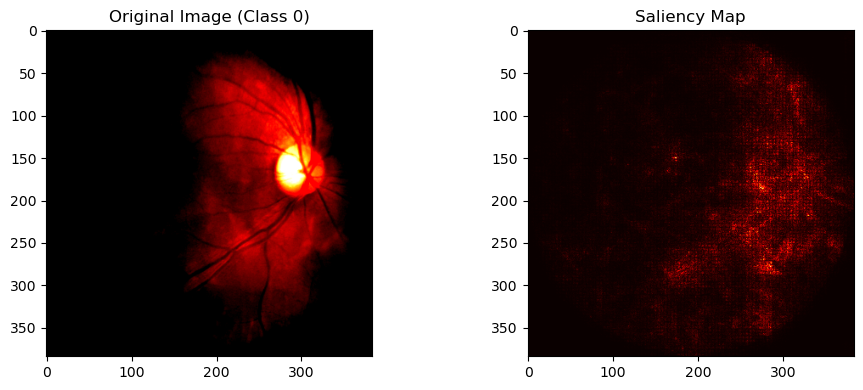

Class 1:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


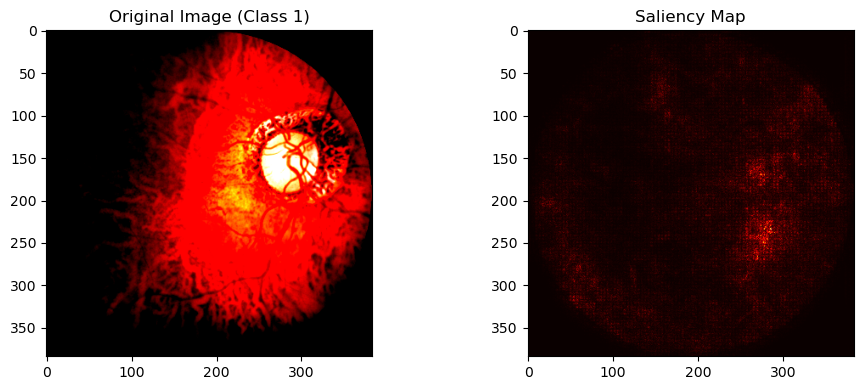

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


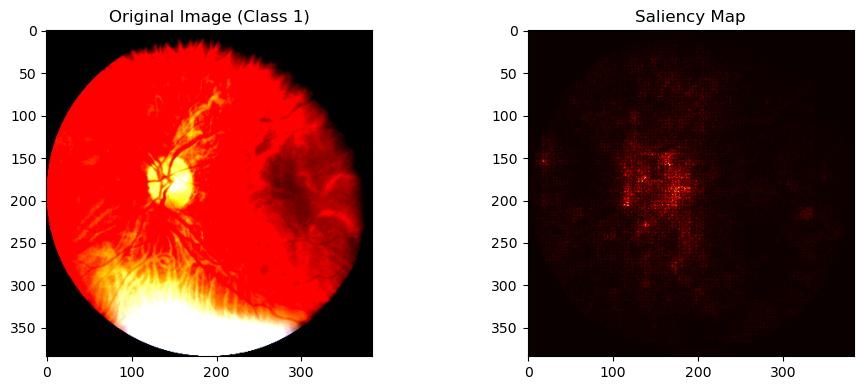

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


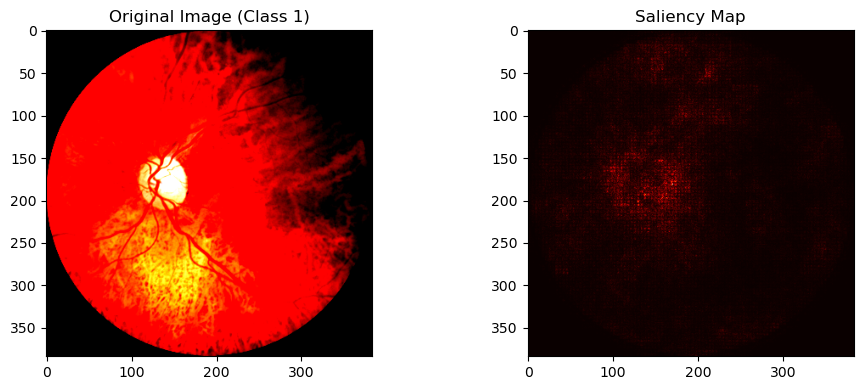

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


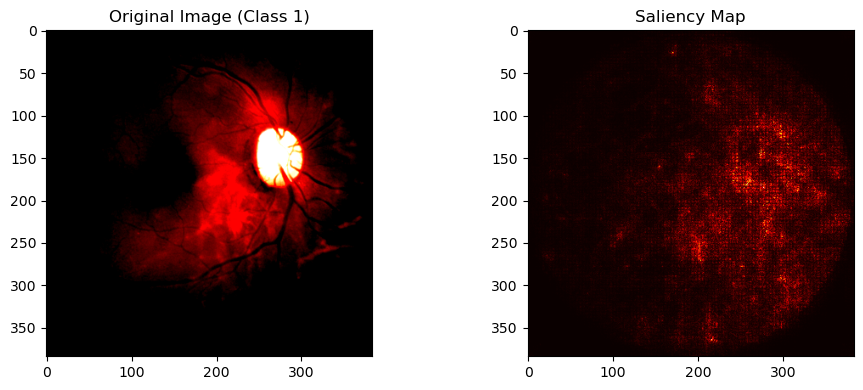

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


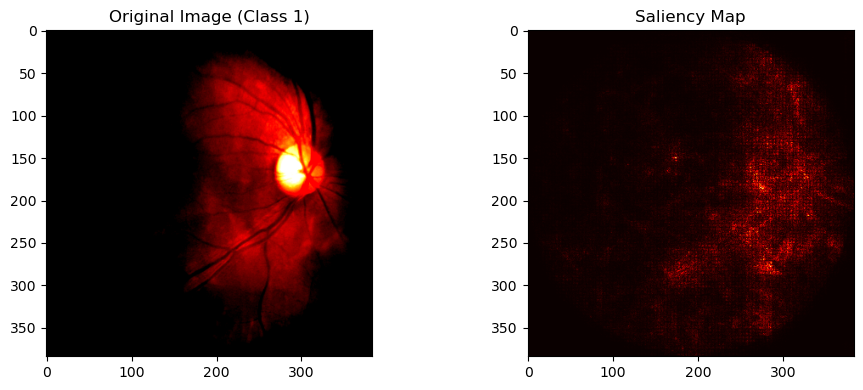

In [82]:
test(model, test_dataloader, saliency=True, device=device)

## Test on external set

Replace with path to portable fundus images collected

In [ ]:
EXT_PATH = './OptomedSet'

In [ ]:
from PIL import Image

# List all jpg files in EXT_PATH
ext_images = [f for f in os.listdir(EXT_PATH) if f.lower().endswith('.jpg')]
if ext_images:
    img_path = os.path.join(EXT_PATH, ext_images[0])
    img = Image.open(img_path)
    img.show()
    print(img.size)
    print(f"Displayed image: {img_path}")
else:
    print("No jpg images found in EXT_PATH.")

(2368, 1776)
Displayed image: ./OptomedSet/IM0081EY.JPG


In [ ]:
EXT_SHAPE = (2368, 1776)
ext_test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    ext_test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

### Modify labels accordingly

In [ ]:
ext_dataset = BRSETDataset(
    pd.DataFrame({LABEL:['1' for i in range(len(ext_images))], IMAGE_COL:ext_images}), 
    IMAGE_COL, 
    EXT_PATH, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=ext_test_transform
)

In [ ]:
ext_dataloader = DataLoader(ext_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


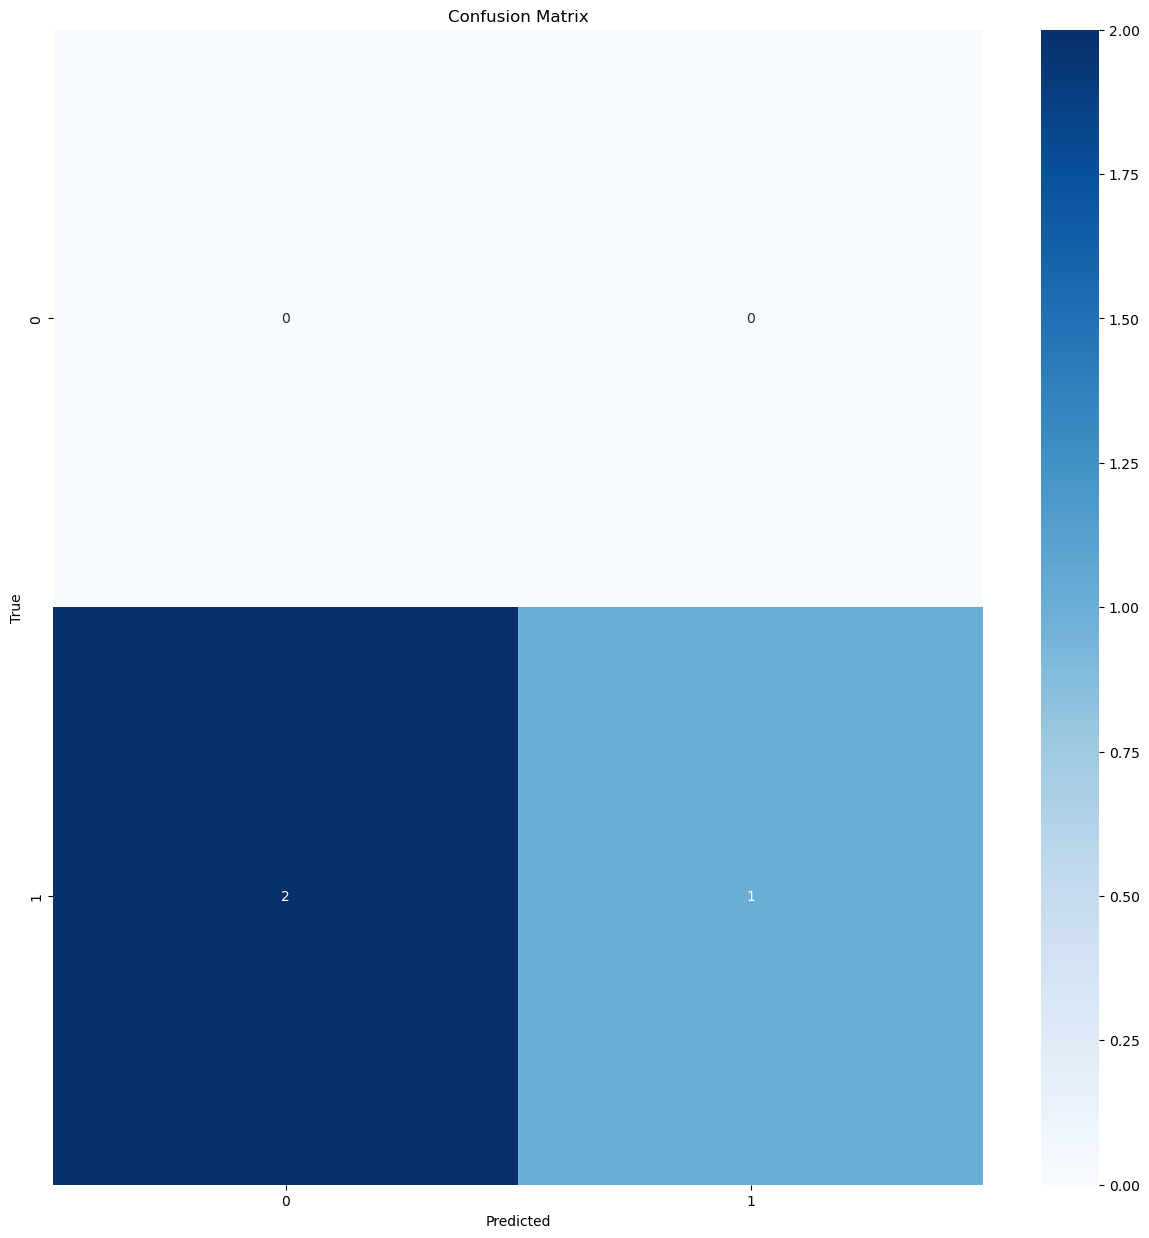

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.33      0.50         3

    accuracy                           0.33         3
   macro avg       0.50      0.17      0.25         3
weighted avg       1.00      0.33      0.50         3

##################################################  Saliency Maps  ##################################################

Class 0:
Class 1:


In [ ]:
test(model,ext_dataloader,saliency=True)